### 0. 專案說明（Markdown）
#### 台北捷運站點：合成對照 + XGBoost 反事實（含 HHI 懲罰）
##### - **資料**：每小時出站寬表 -> 聚合成日
##### - **donor 選取**：pre 期做 z-score -> PCA(保留率) -> KMeans；不足用相關性補
##### - **模型**：XGBoost（pre 期訓練 + time-based split）
##### - **搜尋**：以 `score = RMSE_valid + λ * HHI` 挑最佳（避免單一 donor 過重）
##### - **分析**：反事實、placebo、block bootstrap 95% CI、特徵重要度

### 1. 環境、套件與字型設定

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"      # 對 OpenMP 生效
os.environ["MKL_NUM_THREADS"] = "1"      #（可選）對 MKL BLAS 生效
os.environ["OPENBLAS_NUM_THREADS"] = "1" #（可選）若用到 OpenBLAS

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import ParameterSampler

import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

np.random.seed(42)

cjk_candidates = [
    "Microsoft JhengHei", "PingFang TC", "Noto Sans CJK TC",
    "Noto Sans CJK JP", "SimHei", "WenQuanYi Zen Hei",
    "PMingLiU", "MingLiU", "Heiti TC"
]
available = {f.name for f in fm.fontManager.ttflist}
pick = next((f for f in cjk_candidates if f in available), None)

if pick:
    matplotlib.rcParams["font.sans-serif"] = [pick]
    matplotlib.rcParams["font.family"] = "sans-serif"
    matplotlib.rcParams["axes.unicode_minus"] = False  # 修正負號

print("使用字型：", pick or "系統預設（可能不支援中文）")

使用字型： Microsoft JhengHei


### 2. 路徑、事件窗、全域參數

In [2]:
# %%
# -----------------------------
# 0) 路徑與事件設定
# -----------------------------
CSV = "../data/exits_by_station_hour.csv"      # 寬表：time + 各站欄位
OUTBOUND_CSV = "../data/出國旅客按目的地統計.csv"
TARGET = "松山機場"

# 事件窗（你提供的第二組設定）
EVENT_START = pd.Timestamp("2022-05-09")  # 7+7 上路: 05/09（0+7: 10/13）
PRE_START   = pd.Timestamp("2021-05-23")
POST_END    = pd.Timestamp("2022-10-13")

# Placebo 視窗（做為 post 期對照）
PLACEBO_START = pd.Timestamp("2022-05-09")
PLACEBO_END   = pd.Timestamp("2022-10-13")

# 分群與 donor 下限
N_CLUSTERS     = 8     # KMeans 初始群數（實際會在搜尋時嘗試不同值）
N_MIN_DONORS   = 5     # 至少的 donor 數
LAMBDA_HHI     = 0.05  # 複合分數中的 HHI 權重，可視資料調 0.01~0.2

### 3. 載入資料：小時 → 日（含 robust CSV 讀取）

In [3]:
# %%
def read_df(path: str) -> pd.DataFrame:
    """
    穩健讀取 CSV，time 解析成 DatetimeIndex，缺失補 0，依時間排序。
    """
    try:
        df = pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding="utf-8-sig")

    df["time"] = pd.to_datetime(df["time"], errors="coerce", infer_datetime_format=True)
    df = df.dropna(subset=["time"]).set_index("time").sort_index()
    return df.fillna(0)

raw = read_df(CSV)
daily = raw.resample("D").sum()

assert TARGET in daily.columns, f"找不到欄位：{TARGET}（請確認 {CSV} 是否為時間 × 站點的寬表）"
print("日資料維度：", daily.shape, "範圍：", daily.index.min().date(), "~", daily.index.max().date())


日資料維度： (3103, 122) 範圍： 2017-01-01 ~ 2025-06-30


C:\Users\User\AppData\Local\Temp\ipykernel_62168\3029724722.py:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["time"] = pd.to_datetime(df["time"], errors="coerce", infer_datetime_format=True)


### 4. 外生變數：出國旅客（自動找日期欄，對齊日頻）

In [4]:
# %%
# 專讀 /mnt/data/出國旅客按目的地統計.csv -> outbound_daily（日頻）
def load_outbound_daily_feature_from_tourism(path, daily_index, col_name="outbound_daily"):
    import pandas as pd, numpy as np
    # 讀檔
    for enc in ["utf-8", "utf-8-sig", "cp950", "big5"]:
        try:
            df = pd.read_csv(path, encoding=enc)
            break
        except Exception:
            df = None
    if df is None:
        raise RuntimeError(f"無法讀取檔案：{path}")

    # 必要欄
    need = ["年別","月份","小計"]
    miss = [c for c in need if c not in df.columns]
    if miss:
        raise ValueError(f"檔案缺少欄位：{miss}（需要 年別、月份、小計）")

    # 轉西元年（若是民國年 e.g., 111 → 2022）
    y = pd.to_numeric(df["年別"], errors="coerce")
    y = y.where(y >= 1911, y + 1911)

    m = pd.to_numeric(df["月份"], errors="coerce")

    # 月起始日期
    month_start = pd.to_datetime(dict(year=y, month=m, day=1), errors="coerce")

    # 每月總量（小計）
    total = pd.to_numeric(df["小計"], errors="coerce")
    monthly = pd.Series(total.values, index=month_start).groupby(level=0).sum().sort_index()

    # 月均分到日：每月總量 / 當月天數
    parts = []
    for ms, tot in monthly.items():
        month_end = (ms + pd.offsets.MonthEnd(1))
        days = pd.date_range(ms, month_end, freq="D")
        per_day = float(tot) / len(days) if len(days) else np.nan
        parts.append(pd.Series(per_day, index=days))
    daily_series = pd.concat(parts, axis=0).sort_index()

    # 對齊到 metro 的 daily.index，前後用 ffill/bfill 補齊
    out = pd.Series(index=daily_index, dtype=float)
    out.loc[daily_series.index] = daily_series.values
    out = out.ffill().bfill()

    return pd.DataFrame({col_name: out}, index=daily_index)

exo_all = load_outbound_daily_feature_from_tourism(  # ← 不變
    OUTBOUND_CSV, daily.index, col_name="outbound_daily"
)
exo_cols = list(exo_all.columns)
print(f"[Exogenous] 已載入外生特徵：{exo_cols}")

[Exogenous] 已載入外生特徵：['outbound_daily']


### 5. pre 期 KMeans 分群選 donors

In [5]:
pre_mask = (daily.index >= PRE_START) & (daily.index < EVENT_START)
pre_mat = daily.loc[pre_mask]

def pick_donors(pre_mat: pd.DataFrame, target: str, n_clusters: int, pca_var: float, n_min_donors: int):
    """
    pre 期：z-score -> PCA(保留率) -> KMeans，與 target 同群者為候選；
    若不足 n_min_donors，按與 target 的 pre 期相關性由高到低補齊。
    """
    Z = StandardScaler(with_mean=True, with_std=True).fit_transform(pre_mat.T)  # stations × T_pre
    pca = PCA(n_components=pca_var, svd_solver="full", random_state=42)
    Z_pca = pca.fit_transform(Z)

    km = KMeans(n_clusters=n_clusters, n_init="auto", random_state=42)
    labels = km.fit_predict(Z_pca)

    target_idx = list(pre_mat.columns).index(target)
    cluster_of_target = labels[target_idx]
    cluster_members = [c for c, lab in zip(pre_mat.columns, labels) if lab == cluster_of_target and c != target]

    donors = cluster_members.copy()
    if len(donors) < n_min_donors:
        corr = pre_mat.corr()[target].drop(target).abs().sort_values(ascending=False)
        for c in corr.index:
            if c not in donors:
                donors.append(c)
            if len(donors) >= max(n_min_donors, len(cluster_members) + 10):
                break
    return donors, cluster_members

donors_init, cluster_members = pick_donors(pre_mat, TARGET, N_CLUSTERS, pca_var=0.95, n_min_donors=N_MIN_DONORS)
print(f"[KMeans] 與 {TARGET} 同群站點（移除自身）：{cluster_members[:10]}{'...' if len(cluster_members)>10 else ''}")
print(f"[Donor 最終名單(初始)] {len(donors_init)} 站；前 10：{donors_init[:10]}")

[KMeans] 與 松山機場 同群站點（移除自身）：['G大坪林', 'O景安', 'O頭前庄', '中原', '中和', '先嗇宮', '動物園', '十四張', '南港軟體園區', '大湖公園']...
[Donor 最終名單(初始)] 26 站；前 10：['G大坪林', 'O景安', 'O頭前庄', '中原', '中和', '先嗇宮', '動物園', '十四張', '南港軟體園區', '大湖公園']


### 6. 日曆特徵

In [6]:
def calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    """
    週期性與虛擬變數：
    - dow/doy 的 sin/cos
    - 週幾 one-hot（drop_first）
    - is_weekend 可在診斷時再生
    """
    dfc = pd.DataFrame(index=idx)
    dfc["dow"] = idx.dayofweek
    dfc["doy"] = idx.dayofyear

    dfc["dow_sin"] = np.sin(2*np.pi*dfc["dow"]/7)
    dfc["dow_cos"] = np.cos(2*np.pi*dfc["dow"]/7)
    dfc["doy_sin"] = np.sin(2*np.pi*dfc["doy"]/365.25)
    dfc["doy_cos"] = np.cos(2*np.pi*dfc["doy"]/365.25)

    dummies = pd.get_dummies(dfc["dow"], prefix="dow", drop_first=True)
    return pd.concat([dfc[["dow_sin","dow_cos","doy_sin","doy_cos"]], dummies], axis=1)

cal_all = calendar_features(daily.index)

### 7. 組合特徵與 pre 期切分（原樣）

In [7]:
X_all = daily[donors_init].copy()
y_all = daily[TARGET].copy()

X = pd.concat([X_all, cal_all, exo_all], axis=1)
y = y_all

pre_mask = (X.index >= PRE_START) & (X.index < EVENT_START)
pre_X, pre_y = X.loc[pre_mask], y.loc[pre_mask]

N = len(pre_X)
i70, i80, i90 = int(N*0.7), int(N*0.8), int(N*0.9)

idx_train = pre_X.index[:i80]
idx_valid = pre_X.index[i80:i90]     # pre 的 80%~90%
idx_test  = pre_X.index[i90:]        # pre 的 90%~100%

X_tr, y_tr = pre_X.loc[idx_train], pre_y.loc[idx_train]
X_va, y_va = pre_X.loc[idx_valid], pre_y.loc[idx_valid]

print(f"pre 期樣本數：{N}（train: {len(idx_train)} / valid: {len(idx_valid)} / test: {len(idx_test)}）")

pre 期樣本數：351（train: 280 / valid: 35 / test: 36）


### 8. HHI 計算（依 XGBoost gain 反推 donor 集中度）

In [8]:
# %%
def donor_concentration_from_gain(model, X_columns, donor_cols):
    """
    從 XGBoost 的 'gain' 推 donor 重要度分佈，回傳 HHI / N_eff / max_share。
    兼容 f0,f1,... 與真實欄名；若沒有重要度紀錄則均分。
    """
    booster = model.get_booster()
    fscore = booster.get_score(importance_type="gain")  # 可能是 {'f0':...} 或 {'站A':...}

    if not fscore:
        p = np.ones(len(donor_cols)) / max(1, len(donor_cols))
        hhi = float((p**2).sum())
        return {"HHI": hhi, "N_eff": float(1/hhi), "max_share": float(p.max()), "p": dict(zip(donor_cols, p))}

    keys = list(fscore.keys())
    if all(isinstance(k, str) and k.startswith("f") and k[1:].isdigit() for k in keys):
        idx_map = {f"f{i}": col for i, col in enumerate(list(X_columns))}
        gain_named = {idx_map[k]: v for k, v in fscore.items() if k in idx_map}
    else:
        gain_named = fscore

    g = np.array([float(gain_named.get(c, 0.0)) for c in donor_cols], dtype=float)
    if g.sum() <= 0:
        p = np.ones(len(donor_cols)) / max(1, len(donor_cols))
    else:
        p = g / g.sum()

    hhi = float((p**2).sum())
    return {"HHI": hhi, "N_eff": float(1/hhi), "max_share": float(p.max()), "p": dict(zip(donor_cols, p))}

### 9. 超參數搜尋（PCA/KMeans/ XGBoost）＋ 複合分數

In [9]:
# %%
search_space = {
    "pca_var": [0.90, 0.95, 0.99],
    "n_clusters": [6, 8, 10, 12],
    "learning_rate": [0.02, 0.05, 0.10],
    "max_depth": [3, 4, 5, 6],
    "min_child_weight": [3, 5, 10],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.7, 0.85, 1.0],
    "gamma": [5, 10, 50, 100],
    "reg_alpha": [1, 10, 100],
    "reg_lambda": [0.1, 1, 5, 10],
}
n_iter = 40
param_list = list(ParameterSampler(search_space, n_iter=n_iter, random_state=42))

results = []
best_model = None
best_cfg   = None
best_rmse  = float("inf")
best_score = float("inf")

for i, p in enumerate(param_list, 1):
    donors_try, _ = pick_donors(pre_mat, TARGET, p["n_clusters"], p["pca_var"], N_MIN_DONORS)

    X_try_all = daily[donors_try].copy()
    X_try = pd.concat([X_try_all, cal_all, exo_all], axis=1)
    pre_X_try = X_try.loc[pre_mask]

    split_try = int(len(pre_X_try) * 0.8)
    X_tr, X_va = pre_X_try.iloc[:split_try], pre_X_try.iloc[split_try:]
    y_tr, y_va = pre_y.iloc[:split_try],  pre_y.iloc[split_try:]

    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=5000,
        learning_rate=p["learning_rate"],
        max_depth=p["max_depth"],
        min_child_weight=p["min_child_weight"],
        subsample=p["subsample"],
        colsample_bytree=p["colsample_bytree"],
        gamma=p["gamma"],
        reg_alpha=p["reg_alpha"],
        reg_lambda=p["reg_lambda"],
        eval_metric="rmse",
        early_stopping_rounds=100,
        random_state=42,
        tree_method="hist",
        verbosity=0,
    )
    model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

    pred_va = model.predict(X_va)
    val_rmse = float(np.sqrt(mean_squared_error(y_va, pred_va)))

    cm = donor_concentration_from_gain(model, X_try.columns, donors_try)
    score = val_rmse + LAMBDA_HHI * cm["HHI"]

    results.append({
        **p,
        "n_donors": len(donors_try),
        "val_rmse": val_rmse,
        "HHI": cm["HHI"],
        "N_eff": cm["N_eff"],
        "max_share": cm["max_share"],
        "score": score,
        "best_iteration": getattr(model, "best_iteration", None),
    })

    if (score < best_score) or (np.isclose(score, best_score) and val_rmse < best_rmse):
        best_score = score
        best_rmse  = val_rmse
        best_model = model
        best_cfg   = {**p, "donors": donors_try}

    if i % 10 == 0:
        print(f"[Search] tried {i}/{len(param_list)}; best score={best_score:.4f} (rmse={best_rmse:.4f})")

res_df = pd.DataFrame(results).sort_values(["score","val_rmse"]).reset_index(drop=True)
print("\nTop-5 configs by composite score:")
cols_show = ["score","val_rmse","HHI","N_eff","max_share","n_donors","learning_rate","max_depth","subsample","colsample_bytree"]
print(res_df.head(5)[cols_show])

donors = best_cfg["donors"]
print(f"\n[Best donors] {len(donors)}：{donors[:10]}{'...' if len(donors) > 10 else ''}")
print(f"[Best XGB cfg] {{k: best_cfg[k] for k in best_cfg if k!='donors'}} ->", {k: best_cfg[k] for k in best_cfg if k!='donors'})
print(f"[Best valid RMSE] {best_rmse:.2f}")
print(f"[Best iteration] {getattr(best_model, 'best_iteration', None)}")

[Search] tried 10/40; best score=337.6743 (rmse=337.6619)
[Search] tried 20/40; best score=330.4325 (rmse=330.4258)
[Search] tried 30/40; best score=330.4325 (rmse=330.4258)
[Search] tried 40/40; best score=330.4325 (rmse=330.4258)

Top-5 configs by composite score:
        score    val_rmse       HHI     N_eff  max_share  n_donors  \
0  330.432489  330.425779  0.134205  7.451286   0.264721        37   
1  330.442362  330.423119  0.384870  2.598277   0.482465        37   
2  337.674342  337.661871  0.249422  4.009275   0.366914        37   
3  344.827699  344.820504  0.143902  6.949167   0.286405        37   
4  349.704480  349.696453  0.160530  6.229358   0.284207        37   

   learning_rate  max_depth  subsample  colsample_bytree  
0           0.02          4        0.7              1.00  
1           0.05          6        1.0              0.85  
2           0.10          3        1.0              0.85  
3           0.10          3        0.7              1.00  
4           0.05 

### 10. 以最佳 donors + 模型重建全資料特徵

In [10]:
# %%
X_all = daily[donors].copy()
X = pd.concat([X_all, cal_all, exo_all], axis=1)
y = y_all

# 重新定義切割遮罩（以防長度不一致）
pre_mask  = (X.index >= PRE_START) & (X.index < EVENT_START)
post_mask = (X.index >= EVENT_START) & (X.index <= POST_END)

pre_X,  post_X  = X.loc[pre_mask],  X.loc[post_mask]
pre_y,  post_y  = y.loc[pre_mask],  y.loc[post_mask]

model = best_model

### 11. 特徵重要度（群組：donor vs. calendar/exogenous）


[Feature importance — top 20 by GAIN]
                gain  weight     cover    total_gain  total_cover  gain_pct
奇岩      1.108266e+07   102.0   99.4020  1.130431e+09      10139.0    0.2632
葫洲      7.986606e+06   163.0   94.1288  1.301817e+09      15343.0    0.1897
小南門     3.788571e+06   131.0   87.7634  4.963028e+08      11497.0    0.0900
中原      2.896916e+06   138.0   89.6739  3.997744e+08      12375.0    0.0688
南港軟體園區  2.515938e+06   176.0   96.5625  4.428051e+08      16995.0    0.0598
景平      2.259103e+06   112.0   78.3929  2.530195e+08       8780.0    0.0537
萬芳社區    2.168892e+06   132.0   89.6136  2.862937e+08      11829.0    0.0515
新北產業園區  1.977066e+06   108.0   72.6481  2.135232e+08       7846.0    0.0470
大直      1.915443e+06   165.0   75.7939  3.160480e+08      12506.0    0.0455
東湖      7.334320e+05    93.0   79.6237  6.820918e+07       7405.0    0.0174
板新      6.549140e+05    71.0   54.3380  4.649890e+07       3858.0    0.0156
辛亥      5.452822e+05    93.0   69.9032  5.071125e

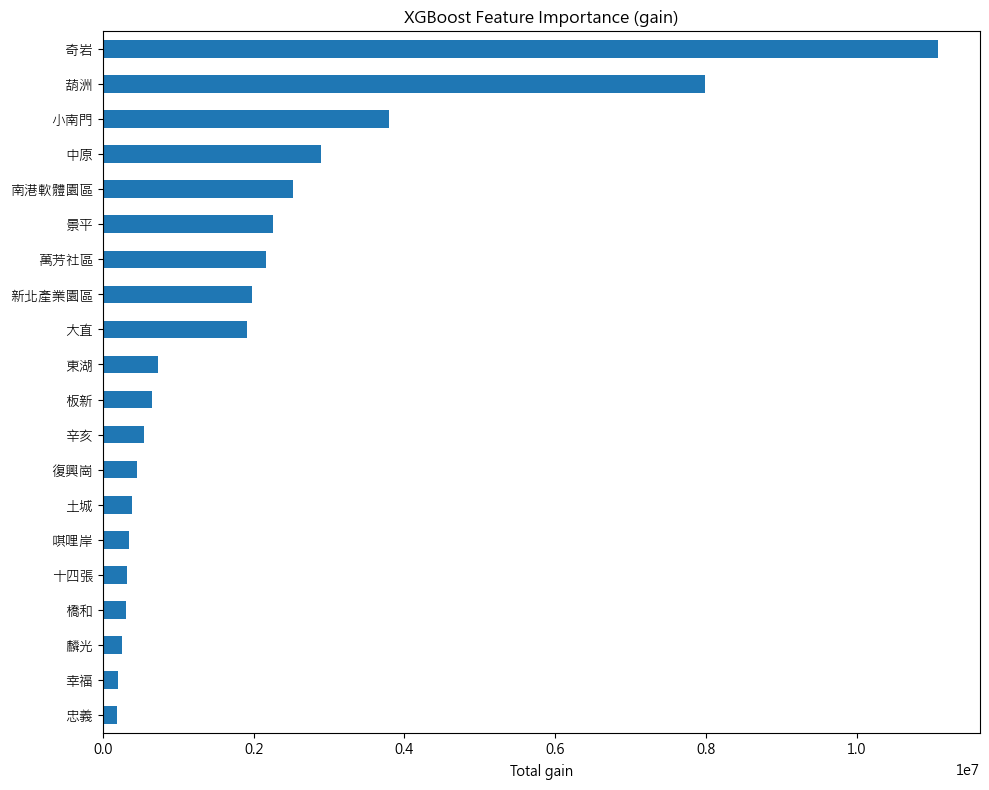

In [11]:
# %%
booster = model.get_booster()
feature_names = getattr(booster, "feature_names", None) or list(X.columns)

def _to_named_series(score_dict, feature_names):
    s = pd.Series(score_dict, dtype=float)
    if not s.empty and all(isinstance(k, str) and k.startswith("f") and k[1:].isdigit() for k in s.index):
        try:
            s.index = [feature_names[int(k[1:])] for k in s.index]
        except Exception:
            pass
    return s.reindex(feature_names, fill_value=0.0)

imp_types = ["gain", "weight", "cover", "total_gain", "total_cover"]
imp_df = pd.DataFrame({t: _to_named_series(booster.get_score(importance_type=t), feature_names)
                       for t in imp_types})
imp_df["gain_pct"] = imp_df["gain"] / (imp_df["gain"].sum() or 1.0)
imp_df = imp_df.sort_values("gain", ascending=False)

print("\n[Feature importance — top 20 by GAIN]")
print(imp_df.head(20).round(4))

donor_cols = list(daily[donors].columns)
cal_exo_cols = [c for c in X.columns if c not in donor_cols]
group_view = pd.DataFrame({
    "group": ["donor" if c in donor_cols else "calendar/exo" for c in imp_df.index],
    "gain": imp_df["gain"].values
}).groupby("group")["gain"].sum().sort_values(ascending=False)

print("\n[Group importance by GAIN]")
print(group_view)

imp_df.to_csv("xgb_feature_importance.csv", encoding="utf-8-sig")
print("已輸出：xgb_feature_importance.csv")

# 視覺化（前 20）
topk = 20
ax = imp_df.head(topk)["gain"].plot(kind="barh", figsize=(10, 8),
                                    title="XGBoost Feature Importance (gain)")
ax.invert_yaxis()
ax.set_xlabel("Total gain")
plt.tight_layout()
plt.show()


### 12. 視覺化：實際 vs 反事實；placebo 區間日增量

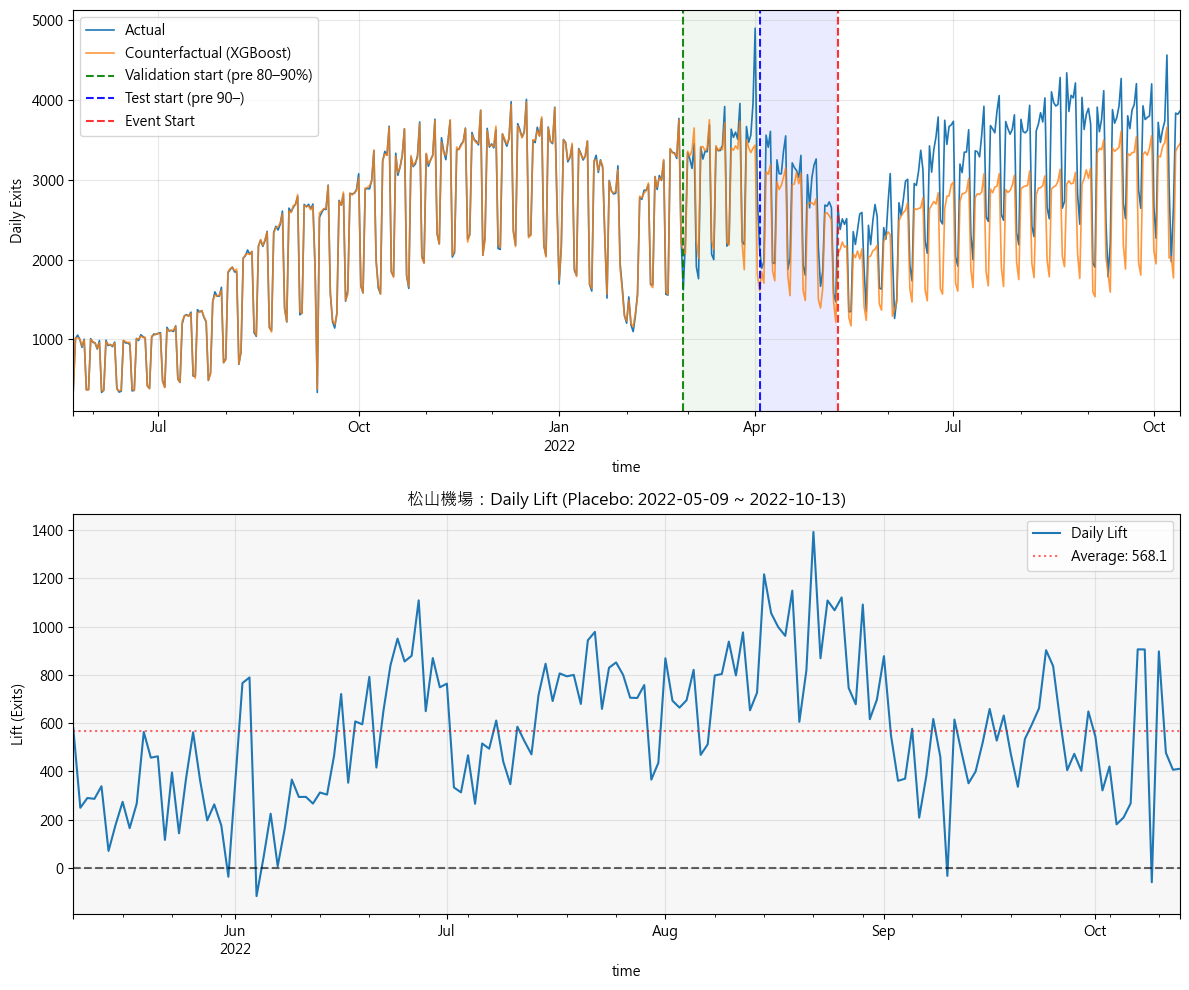

In [12]:
# %%
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# 上圖：全期 Actual vs Counterfactual
pred_pre_full = model.predict(pre_X)
pred_post     = model.predict(post_X)
cf_series = pd.concat([
    pd.Series(pred_pre_full, index=pre_X.index),
    pd.Series(pred_post,     index=post_X.index)
]).rename("counterfactual")
actual_series = y.loc[cf_series.index]
actual_series.plot(ax=ax1, label="Actual", linewidth=1.2)
cf_series.plot(ax=ax1, label="Counterfactual (XGBoost)", linewidth=1.2, alpha=0.8)

# pre 驗證/測試區域
ax1.axvline(idx_valid[0], linestyle="--", alpha=0.9, color="green", label="Validation start (pre 80–90%)")
ax1.axvspan(idx_valid[0], idx_valid[-1], color="green", alpha=0.06)

ax1.axvline(idx_test[0], linestyle="--", alpha=0.9, color="blue", label="Test start (pre 90–)")
ax1.axvspan(idx_test[0], idx_test[-1], color="blue", alpha=0.08)

# 事件線
ax1.axvline(EVENT_START, linestyle="--", alpha=0.8, color='red', label="Event Start")

ax1.set_ylabel("Daily Exits")
ax1.legend()
ax1.grid(True, alpha=0.3)

# 下圖：placebo 視窗的日增量
placebo_mask = (actual_series.index >= PLACEBO_START) & (actual_series.index <= PLACEBO_END)
placebo_actual = actual_series.loc[placebo_mask]
placebo_cf     = cf_series.loc[placebo_mask]
placebo_lift   = placebo_actual - placebo_cf

ax2.clear()
placebo_lift.plot(ax=ax2, label="Daily Lift")
ax2.axvspan(PLACEBO_START, PLACEBO_END, color="gray", alpha=0.06)
ax2.axhline(0, linestyle="--", alpha=0.6, color='black')
ax2.axhline(placebo_lift.mean(), linestyle=":", alpha=0.6, color='red',
            label=f"Average: {placebo_lift.mean():.1f}")
ax2.set_ylabel("Lift (Exits)")
ax2.set_title(f"{TARGET}：Daily Lift (Placebo: {PLACEBO_START.date()} ~ {PLACEBO_END.date()})")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 13. 診斷：RMSE（全體/平日/週末）與週別平均殘差

In [13]:
# %%
def rmse(a, b):
    try:
        return root_mean_squared_error(a, b)
    except TypeError:
        return float(np.sqrt(mean_squared_error(a, b)))

pre_actual = actual_series.loc[:EVENT_START - pd.Timedelta(days=1)]
pre_cf     = cf_series.loc[pre_actual.index]

diag = pd.DataFrame({"y": pre_actual, "yhat": pre_cf}, index=pre_actual.index)
diag["dow"] = diag.index.dayofweek
diag["is_weekend"] = (diag["dow"] >= 5).astype(int)

print("RMSE(all):", rmse(diag.y, diag.yhat), "MAE(all):", mean_absolute_error(diag.y, diag.yhat))
print("RMSE(weekday):", rmse(diag.loc[diag.is_weekend == 0, "y"], diag.loc[diag.is_weekend == 0, "yhat"]))
print("RMSE(weekend):", rmse(diag.loc[diag.is_weekend == 1, "y"], diag.loc[diag.is_weekend == 1, "yhat"]))

print("週別平均殘差：")
print(diag.groupby("dow").apply(lambda g: float((g.y - g.yhat).mean())))


RMSE(all): 149.921875 MAE(all): 61.726356506347656
RMSE(weekday): 141.43539428710938
RMSE(weekend): 169.10606384277344
週別平均殘差：
dow
0    36.062819
1    14.891727
2    26.847961
3    35.121473
4    68.798009
5    31.418924
6    31.480488
dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_62168\2729790573.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(diag.groupby("dow").apply(lambda g: float((g.y - g.yhat).mean())))


### 14. Block Bootstrap：累積 Lift 的 95% 信賴區間

In [14]:
# %%
def block_bootstrap_ci_by_index(actual, cf, pre_idx, post_idx, block=7, B=2000, seed=42):
    """
    以 pre 期殘差做區塊自助法（block bootstrap），模擬 post 期殘差路徑，
    得到 post 期『累積 Lift』的 95% CI。
    - block: 以 7 天為一區塊，保留週期性
    """
    assert actual.index.equals(cf.index)

    resid_pre = (actual.loc[pre_idx] - cf.loc[pre_idx]).to_numpy()
    T_post = len(post_idx)

    if len(resid_pre) == 0:
        raise ValueError("pre period residuals is empty.")
    block = max(1, min(block, len(resid_pre)))

    blocks = [resid_pre[i:i+block] for i in range(0, len(resid_pre)-block+1)]
    if not blocks:
        blocks = [resid_pre]  # pre 太短時退而求其次

    rng = np.random.default_rng(seed)
    ypost  = actual.loc[post_idx].to_numpy()
    cfpost = cf.loc[post_idx].to_numpy()

    cum_lifts = []
    for _ in range(B):
        path = []
        while len(path) < T_post:
            path.extend(blocks[rng.integers(0, len(blocks))])
        path = np.asarray(path[:T_post])
        cum_lifts.append((ypost - (cfpost + path)).sum())

    lo, hi = np.percentile(cum_lifts, [2.5, 97.5])
    return float(lo), float(hi)

# 計算 CI
lo, hi = block_bootstrap_ci_by_index(
    actual_series, cf_series,
    pre_idx=pre_X.index,
    post_idx=post_X.index,
    block=7, B=2000
)
print(f"累積 Lift 95% CI: [{lo:,.0f}, {hi:,.0f}]")


累積 Lift 95% CI: [76,330, 90,628]


### 15. 補充：事件前/後均值與相對提升

In [15]:
# %%
post_actual = actual_series.loc[post_X.index]
post_cf     = cf_series.loc[post_X.index]

print("\n[額外統計]")
print(f" 事件前平均（實際）：{actual_series.loc[pre_X.index].mean():.1f}")
print(f" 事件後平均（實際）：{post_actual.mean():.1f}")
print(f" 事件後平均（反事實）：{post_cf.mean():.1f}")
print(f" 提升比例：{(post_actual.mean() / post_cf.mean() - 1) * 100:.2f}%")


[額外統計]
 事件前平均（實際）：2330.4
 事件後平均（實際）：3095.6
 事件後平均（反事實）：2527.5
 提升比例：22.48%
